In [1]:
from loadingCGAN.novgan import Novgan
from load_data.load_data import load_data
from utils.config_novgan import nrows, place, activation, latent_dim, leaky_relu, alpha, offset
from utils.config_novgan import balanced_train_size, shuffle, cv_size, smooth_one, smooth_zero, batch_size
from loadingCGAN.utils_cgan import creating_dico_index
import numpy as np

Using TensorFlow backend.


In [2]:
# DATA
x_train, x_train_cv, y_train, y_train_cv, x_balanced_train, y_balanced_train, x_test, y_test, colnames = load_data(place=place,
                                                                                                                   verbose=False,
                                                                                                                   nrows=nrows,
                                                                                                                   cv_size=cv_size,
                                                                                                                   log_transform=True,
                                                                                                                   shuffle=shuffle, return_colnames=True)
if balanced_train_size is not None:
    x_balanced_train, y_balanced_train = x_balanced_train[:balanced_train_size], y_balanced_train[:balanced_train_size]

data_dim = x_train.shape[1]

print(data_dim)

/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


122


In [3]:
dico_index = creating_dico_index(colnames=colnames)

print(dico_index)

{'num_access_files': 11, 'num_shells': 10, 'src_bytes': 1, 'dst_bytes': 2, 'root_shell': 34, 'num_root': 8, 'su_attempted': 37, 'num_file_creations': 9}


# NovGan 

In [4]:
novgan = Novgan(data_dim=data_dim, activation=activation, verbose=True,
                latent_dim=latent_dim,
                leaky_relu=leaky_relu, offset=offset, alpha=alpha, dropout=.2,
                dico_index=dico_index,
                noise="normal",
                smooth_one=smooth_one, smooth_zero=smooth_zero, batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.
CHOSEN OPTIMIZER IS ADAM

 
 Generator Architecture 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                3264      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 122)               15738     
Total params: 27,322
Trainable params: 27,322
Non-trainable params: 0
_________________________________________________________________
Instructions 

In [5]:
x = novgan.gan.loss(y_true=np.ones(1), y_pred=novgan.discriminator.predict(novgan.generate(1))[0])

In [6]:
dico_index["root_shell"]

34

In [7]:
novgan.discriminator.evaluate(x_test[:1], np.zeros(1))

1/1 [==============================] - 0s 29ms/step


1.4410496950149536

In [8]:
novgan.generate(1)

array([[-3.57836396e-01, -2.40170971e-01,  6.17761910e-01,
         4.21874851e-01,  5.98325789e-01, -1.47016138e-01,
         2.03336492e-01,  4.72753495e-01, -2.99418896e-01,
        -2.98380941e-01,  5.29275164e-02,  6.58842549e-02,
        -3.30174595e-01, -5.83755732e-01, -4.86912757e-01,
        -7.41322815e-01, -4.02606577e-01,  2.26165965e-01,
        -7.36953735e-01, -2.45988339e-01,  6.85438693e-01,
         1.90775245e-01,  4.52914201e-02, -1.97554454e-01,
        -2.60531366e-01, -2.94368088e-01,  5.52503288e-01,
         1.08068839e-01,  6.92036629e-01, -4.07111287e-01,
         7.31732666e-01, -5.59507132e-01, -1.09112374e-01,
         7.20791042e-01,  6.44313037e-01,  2.01583698e-01,
         1.86177373e-01,  6.45056129e-01,  4.58213031e-01,
         2.73944378e-01, -1.19219281e-01, -7.65826628e-02,
        -1.39387295e-01, -5.75172782e-01,  3.88916016e-01,
         1.68995466e-02, -1.13205090e-01,  3.80498797e-01,
         7.52105892e-01,  1.34788603e-01,  8.45044076e-0

/home/peseux/.local/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


683.7234464883804
107.75051422417164
635.4040719270706
124.7746799737215
591.9182845950127
141.82548581063747
586.5917547941208
146.70935033261776
540.9918575286865
168.5640260130167
531.3356814980507
174.78276392817497
476.4107412099838
207.64759156107903
434.3006122112274
239.1081435084343
427.3222609758377
246.90983265638351
426.4490203857422
256.7203172147274
394.5513528585434
290.19176840782166
367.2790894508362
328.29906964302063
477.4748486280441
259.11405849456787
523.1278762221336
232.67201825976372
562.302962064743
192.50476014614105
538.2829458713531
199.75371804833412
516.0552139282227
212.68793532252312
524.6670769453049
205.5268533229828
524.5014139413834
203.32693937420845
517.8041320443153
202.43095162510872
500.17334496974945
214.64712092280388
477.368291079998
227.06477835774422
494.1920590996742
217.91422745585442
502.93341904878616
221.25874656438828
479.5420161485672
232.6532030403614
459.53556591272354
249.5639033615589
525.6051531434059
213.24263259768486
492.299

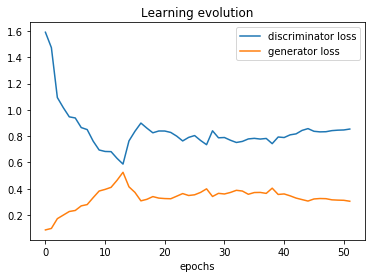

True

In [38]:
learned = novgan.train(x_train=x_train, epochs=50, print_recap=False)


novgan.plot_learning()

In [39]:
novgan.history

{'d_loss': [1.5907649287223815,
  1.4736153560638428,
  1.0939575143814086,
  1.016646515083313,
  0.9470692553520202,
  0.9385468076705933,
  0.8655869720458984,
  0.8501370903968811,
  0.7622571859359741,
  0.6948809795379639,
  0.6837156175613404,
  0.6823184326171875,
  0.6312821645736695,
  0.5876465431213379,
  0.7639597578048706,
  0.8370046019554138,
  0.8996847393035888,
  0.8612527133941651,
  0.8256883422851562,
  0.8394673231124878,
  0.8392022623062134,
  0.8284866112709045,
  0.8002773519515991,
  0.7637892657279969,
  0.7907072945594787,
  0.8046934704780578,
  0.7672672258377076,
  0.7352569054603577,
  0.8409682450294494,
  0.7876793579101562,
  0.789773268699646,
  0.7690955554008484,
  0.752064627456665,
  0.7600926177024842,
  0.7790303357124329,
  0.783458348274231,
  0.778059917640686,
  0.7827101428985596,
  0.7430497399330139,
  0.7937196319580078,
  0.789700836277008,
  0.8100490984916687,
  0.8175805323600769,
  0.8438594064712525,
  0.8575235449790954,
  0.83

In [21]:
one_index = [i for i in range(len(y_train)) if y_train[i]>.5]
zero_index = [i for i in range(len(y_train)) if y_train[i]<.5]

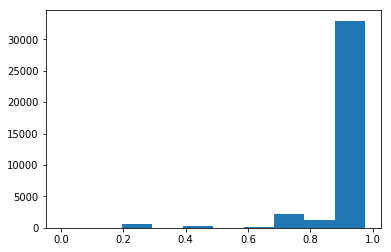

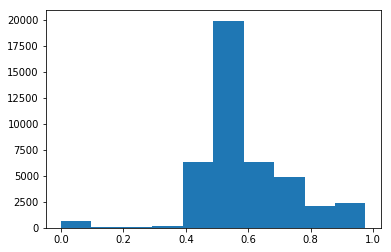

array([0.7112781 , 0.6725111 , 0.78283555, ..., 0.51525871, 0.39464077,
       0.50921204])

In [22]:
novgan.hurting(x_train[one_index], print_mode=True)
novgan.hurting(x_train[zero_index], print_mode=True)

In [24]:
hx = novgan.hurting(x_test, print_mode=False)

In [27]:
y_test

array([0., 0., 1., ..., 0., 0., 1.])

In [34]:
from sklearn.metrics import confusion_matrix as confusion_matrix, precision_score,f1_score, recall_score, accuracy_score


In [35]:
y_pred=[float(h>.8) for h in hx]
y_true=y_test

In [36]:
from sklearn.metrics import confusion_matrix as confusion_matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
ps = .001 * int(1000 * precision_score(y_true=y_true, y_pred=y_pred))
rs = .001 * int(1000 * recall_score(y_true=y_true, y_pred=y_pred))
f1 = .001 * int(1000 * f1_score(y_true=y_true, y_pred=y_pred))
acc = .001 * int(1000 * accuracy_score(y_true=y_true, y_pred=y_pred))
{"confusion_matrix": cm, "precision": ps, "recall": rs, "f1_score": f1, "accuracy": acc}


{'confusion_matrix': array([[48458,  4987],
        [ 4071, 42484]]),
 'precision': 0.894,
 'recall': 0.912,
 'f1_score': 0.903,
 'accuracy': 0.909}